# Introdução

Nesse notebook é realizada a análise preliminar dos dados completos e sua
separação em dados de treinamento e teste. Nessa análise preliminar iremos
fazer diagnósticos da qualidade dos dados e quando necessário ajustá-lo. Isso,
compreende correção do tipo dos dados, avaliação da consistência, análise de
dados faltantes (sem considerar técnicas estatísticas de imputação) e remoção
de dados duplicados.

O segundo objetivo é a separação dos dados em dados de treinamento e teste para
que os modelos de classificação e recomendação possam vir a ter sua capacidade
de generalização validada em etapa futura. Nessa etapa também faremos uma
análise da distribuição da variável `category`. Uma vez que deveremos
desenvolver um modelo para prever essa variável é importante que ela seja
bem representada tanto nos dados de treinamento quanto nos de treinamento.

# Imports

In [128]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split

# Carregamento dos dados

In [65]:
df = pd.read_csv(r"..\data\complete_dataset.csv")
df.head()

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
0,11394449,8324141,espirito santo,2,6,Mandala Espírito Santo,mandala mdf,2015-11-14 19:42:12,171.890000,1200.0,1,4,244,NaN,Decoração
1,15534262,6939286,cartao de visita,2,0,Cartão de Visita,cartao visita panfletos tag adesivos copos lon...,2018-04-04 20:55:07,77.670000,8.0,1,5,124,NaN,Papel e Cia
2,16153119,9835835,expositor de esmaltes,1,38,Organizador expositor p/ 70 esmaltes,expositor,2018-10-13 20:57:07,73.920006,2709.0,1,1,59,NaN,Outros
3,15877252,8071206,medidas lencol para berco americano,1,6,Jogo de Lençol Berço Estampado,t jogo lencol menino lencol berco,2017-02-27 13:26:03,118.770004,0.0,1,1,180,1.0,Bebê
4,15917108,7200773,adesivo box banheiro,3,38,ADESIVO BOX DE BANHEIRO,adesivo box banheiro,2017-05-09 13:18:38,191.810000,507.0,1,6,34,NaN,Decoração


In [66]:
df.shape

(38507, 15)

Os dados foram carregados corretamente e ao todo temos 38.507 registro com
15 atributos.

# Análise preliminar dos dados

## Dados faltantes

In [67]:
df.isna().mean().mul(100).round(2)

product_id            0.00
seller_id             0.00
query                 0.00
search_page           0.00
position              0.00
title                 0.00
concatenated_tags     0.01
creation_date         0.00
price                 0.00
weight                0.15
express_delivery      0.00
minimum_quantity      0.00
view_counts           0.00
order_counts         52.95
category              0.00
dtype: float64

Apenas a coluna `order_countts` possui uma quantidade de dados faltantes
significativa (52,95%). Outras colunas que também possuem dados faltantes são
`weight` (0,01%) e `concatenated_tags` (0,15%), porém estes, em um nível
desprezível.

In [68]:
(df["order_counts"] == 0).any()

False

O fato de não termos nenhum registro de `order_counts` como sendo igual a 0.
Pode ser um indicativo de que caso um item não receba ordens na query, a
observação ficará como `missing`. Supondo que esse realmente seja o caso (o que parece ser bastante razoável), para sanarmos essa grande quantidade de dados faltantes em `order_counts` basta preencher dados faltantes dessa coluna com
`0`.

In [69]:
df["order_counts"].fillna(0, inplace=True)
df["order_counts"].isna().any()

False

## Verificando o tipo das variáveis

Para simplificar a conformação dos dados vamos tratar variáveis categóricas
como textuais `object`.

In [70]:
df.dtypes

product_id             int64
seller_id              int64
query                 object
search_page            int64
position               int64
title                 object
concatenated_tags     object
creation_date         object
price                float64
weight               float64
express_delivery       int64
minimum_quantity       int64
view_counts            int64
order_counts         float64
category              object
dtype: object

A primeira variável que será modificada é a `creation_date`. Como não
especificamos no momento do carregamento dos dados qual coluna do dataset
deveria ser parseado para data, esse campo foi carregado como um `object` ao
invés de um `datetime`.

Avaliando as primeiras linhas dessa coluna, vemos que ela aparentemente está
formatada corretamente. Para nos certificarmos que a conversão ocorrerá como
esperado ao invés de deixar que o método de conversão infira o formato da data
esse formato será especificado (`Y-m-d H:M:S`). 

In [71]:
df["creation_date"].head()

0    2015-11-14 19:42:12
1    2018-04-04 20:55:07
2    2018-10-13 20:57:07
3    2017-02-27 13:26:03
4    2017-05-09 13:18:38
Name: creation_date, dtype: object

In [72]:
df["creation_date"] = pd.to_datetime(df["creation_date"], format="Y-m-d H:M:S")
df["creation_date"].head()

0   2015-11-14 19:42:12
1   2018-04-04 20:55:07
2   2018-10-13 20:57:07
3   2017-02-27 13:26:03
4   2017-05-09 13:18:38
Name: creation_date, dtype: datetime64[ns]

Apesar de menor importância outra variável que pode ter seu tipo modificado é
a `order_counts` que antes estava definida como `float`. A variável estava
tipada dessa forma pois possuia registros faltantes entre suas observações.
Como já acabamos com esse problema, faz sentido para esse tipo de dado
convertê-lo para número inteiro.

In [73]:
df["order_counts"] = df["order_counts"].astype("int")
df["order_counts"].head()

0    0
1    0
2    0
3    1
4    0
Name: order_counts, dtype: int32

Por fim, vamos verificar se as variáveis categórias `express_delivery` e
`category`, possuem entre as suas observações apenas valores referentes às suas
categorias.

In [239]:
# verificando se temos apenas registros com observações iguais às esperadas
# tanto para a variável express_delivery quanto para category
assert set(df["express_delivery"].unique()) == set([1, 0])
cat_list = ["Bebê", "Bijuterias e Jóias", "Decoração",
            "Lembrancinhas", "Papel e Cia", "Outros"]
assert set(df["category"].unique()) == set(cat_list)

Após essa última verificação vemos que ambas as variáveis tem o preenchimento
correto de suas categoriais.

## Identificando registros únicos

Nessa etapa vamos analisar a existência de dados duplicados. Porém antes disso,
precisamos saber o que identifica unicamente as nossas observações. Como estamos
lidando com registros de resultados de querys, e supondo que os product_id e
seller_id de fato identificam unicamente cada um dos produtos e vendedores, o
nosso registro único seria a combinação entre essas três variáveis:
`product_id`, `seller_id` e `query`.

In [240]:
unique_grouping = ["product_id", "seller_id", "query"]
df[unique_grouping].nunique()

product_id    29801
seller_id      8515
query          6397
dtype: int64

Apesar de não termos registros duplicados como um todo, identificamos 1.014
combinações duplicadas das três variáveis que escolhemos para identificar
unicamente os nossos registros.

Para compreender melhor o porque isso ocorre, devemos analisar as variações em
outras colunas quando a combinação de produto, vendedor e query é duplicada.
Isso é um primeiro passo para avaliarmos o que vamos fazer com esses potenciais
registros duplicados. Se decidimos manter essas variações, e desconsideramos
combinações de produto, vendedor e query como identificador único da base de
dados. Ou, se pensamos em uma estratégia para unificar essas variações, e
eliminarmos esses registros duplicados.

In [242]:
df.duplicated().sum()

0

In [241]:
df[unique_grouping].duplicated().sum()

1014

Em uma primeira análise dos primeiros 10 registros duplicados, vemos que a grande parte dessas diferenças concentram-se em variáveis numéricas, como `search_page`,
`position`, `price`, `weight`...

Na variável do tipo data (`creation_date`) e nas variáveis categóricas e
textuais referentes ao produto e vendedor (`category`, `concatenated_tags`,
`express_delivery` e `title`) não encontramos variações.

Com isso vamos separar a identificação de divergências entre as observações duplicadas em duas. Primeiro levando em consideração apenas aquelas colunas que aparenetemente não possuem diferenças entre as combinações de produto, vendedor e query, e que por isso poderiam ter os registros duplicados eliminados sem que haja
perda de informação. E em seguida vamos analisar aqueles que existem diferenças
e que a remoção de duplicatas/unificação dos registros iria incorrer em perda
de informação.

In [115]:
duplicated_df = (df.loc[df[unique_grouping].
                        duplicated(keep=False)].
                 sort_values(unique_grouping))
duplicated_df.head(10)

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
12319,1426,793061,saquinho maternidade,3,0,Saquinho de Maternidade Chevron Ursinho,saquinho maternidade fralda vicente lembrancin...,2018-02-26 01:27:53,26.770000,7.0,1,11,3298,0,Bebê
17589,1426,793061,saquinho maternidade,3,2,Saquinho de Maternidade Chevron Ursinho,saquinho maternidade fralda vicente lembrancin...,2018-02-26 01:27:53,24.270000,10.0,1,3,3290,0,Bebê
9826,30989,21626,dia dos pais,3,33,Dia dos Pais Silhouette Molde caixa para Canec...,arquivos silhouette dia pais,2018-06-27 21:27:23,21.250000,7.0,0,4,366,0,Papel e Cia
23224,30989,21626,dia dos pais,3,33,Dia dos Pais Silhouette Molde caixa para Canec...,arquivos silhouette dia pais,2018-06-27 21:27:23,22.450000,10.0,0,0,338,0,Papel e Cia
27973,30989,21626,dia dos pais,3,33,Dia dos Pais Silhouette Molde caixa para Canec...,arquivos silhouette dia pais,2018-06-27 21:27:23,21.960000,6.0,0,4,338,0,Papel e Cia
7500,44878,9988930,dpa,2,0,Kit DPA Lupa e lanterna,uteis educativo festa kits dpa,2018-08-28 17:55:32,15.389999,5.0,1,10,544,0,Lembrancinhas
12151,44878,9988930,dpa,2,35,Kit DPA Lupa e lanterna,uteis educativo festa kits dpa,2018-08-28 17:55:32,14.280000,9.0,1,20,525,13,Lembrancinhas
16412,70393,5508591,dia dos pais,4,28,Chaveiro Colorido Personalizado Dia dos Pais -...,lembrancas brindes lembrancas dia pais chaveir...,2018-07-02 19:06:50,13.200000,15.0,1,300,525,0,Lembrancinhas
37318,70393,5508591,dia dos pais,4,21,Chaveiro Colorido Personalizado Dia dos Pais -...,lembrancas brindes lembrancas dia pais chaveir...,2018-07-02 19:06:50,3.700000,19.0,1,308,485,0,Lembrancinhas
8047,79079,3204847,presente personalizado dia dos pais,3,0,Caneca e Almofada para o Dia dos Pais 2018,almofadas divertidas almofadas personalizadas ...,2018-07-03 16:45:52,77.850000,707.0,1,4,186,1,Decoração


Antes de fazer a checkagem da variedade é importante ter em mente a dimensão
da quantidade de combinações repetidas. Isto pode ser avaliado pela análise
da distribuição da quantidade de registros repetidos por grupamento.

Como podemos observar pela figura abaixo, a grande maioria das combinações,
repetem-se apenas 2 vezes. Dependendo do nível da variação dessas repetições,
isso pode ser um forte indício em favor da remoção das combinações duplicadas.

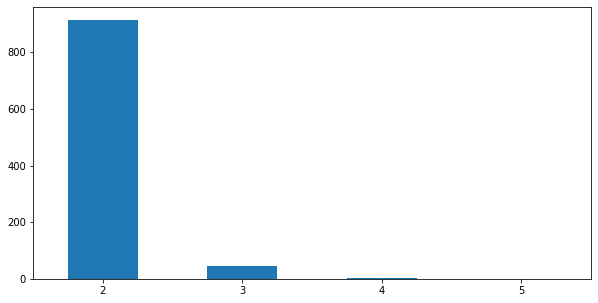

In [180]:
(duplicated_df.
 groupby(unique_grouping).
 size().value_counts().
 plot(kind="bar", figsize=(10, 5)))
plt.xticks(rotation=0)
plt.show()

### Variáveis sem (aparente) variação

Nesse caso a primeira etapa é verificar se realmente não há variação. A forma
com que iremos fazer isso, é comparando para cada combinação a quantidade de
observações repetidas para uma coluna, com a quantidade de vezes que a
combinação se repete. Se ambos os valores forem iguais, toda vez que uma
combinação se repete, ela se repete também com um determinado valor para a
coluna em questão. Ou seja, não há variação.

In [170]:
def compute_duplicates(col: pd.Series) -> int:
    """Computa a quantidade total de registros duplicados para uma série

    Args:
        col (pd.Series): série de valores

    Returns:
        int: quantidade de repetições
    """    
    return col.duplicated(keep=False).sum()

def check_duplicates(col: str,
                     data: pd.DataFrame = duplicated_df,
                     group: list[str] = unique_grouping) -> None:
    """Faz a checkagem se as repetições nos dados ocorrem de forma igual.
    Caso as quantidade duplicadas sejam iguais, o teste passa sem erro.

    Args:
        col (str): coluna a ser textada
        data (pd.DataFrame, optional): grupamento base a ser utilizado.
        Defaults to duplicated_df.
        group (list[str], optional): dados com os registros duplicados.
        Defaults to unique_grouping.
    """
    dupli_counts = (data.groupby(group)[col].apply(compute_duplicates).
                    to_frame("col_duplicate").
                    join(data.groupby(group).
                         size().rename("total_duplicates")))
    check = dupli_counts["col_duplicate"] == dupli_counts["total_duplicates"]
    try:
        assert check.all()
        print("Todos os valores são iguais para um mesmo grupamento")
    except:
        print("Existe variedade na variável para um mesmo grupamento:")
        print(f"Igualdade ocorre em {check.mean():.2%} dos grupamentos")
    finally:
        print("-" * 10)

In [244]:
equal_candidates = ["title", "concatenated_tags",
                    "category", "creation_date", "express_delivery"]
for col in equal_candidates:
    print(f"Checando {col}")
    check_duplicates(col)

Checando title
Todos os valores são iguais para um mesmo grupamento
----------
Checando concatenated_tags
Todos os valores são iguais para um mesmo grupamento
----------
Checando category
Todos os valores são iguais para um mesmo grupamento
----------
Checando creation_date
Todos os valores são iguais para um mesmo grupamento
----------
Checando express_delivery
Existe variedade na variável para um mesmo grupamento:
Igualdade ocorre em 86.07% dos grupamentos
----------


Com excessão da `express_delivery`, para todas as outras, poderíamos eliminar
os grupamentos duplicados de produto, vendedor e query sem perda de informação.

### Variáveis numéricas com variedade já identificadas

Aqui nessa etapa vamos avaliar todas as outras variáveis em que apenas
observando os primeiros registros já conseguimos identificar alguma variação
entre as combinações repetidas. Como os dados são numéricos e de modo a tornar
as variáveis comparáveis vamos utilizar a comparação por meio do indicador de
coeficiente de variação.

Após o cálculo do coeficiente de variação veremos sua distribuição para cada
uma das variáveis utilizando gráficos de box-plot e histograma.

In [116]:
def var_coef(num_series: pd.Series) -> float:
    return num_series.std() / num_series.mean()

In [183]:
numeric_vars = ["search_page", "position",
                "price", "weight", "minimum_quantity", "view_counts",
                "order_counts"]

# o fillna é importante caso tenhamos grupos cuja média é igual a 0
unique_group_stats = (duplicated_df.groupby(unique_grouping)[numeric_vars].
                      apply(var_coef).fillna(0))
unique_group_stats.head()

,,,search_page,position,price,weight,minimum_quantity,view_counts,order_counts
product_id,seller_id,query,,,,,,,
1426,793061,saquinho maternidade,0.0,1.414214,0.069270,0.249567,0.808122,0.001717,0.000000
30989,21626,dia dos pais,0.0,0.000000,0.027567,0.271522,0.866025,0.046543,0.000000
44878,9988930,dpa,0.0,1.414214,0.052908,0.404061,0.471405,0.025136,1.414214
70393,5508591,dia dos pais,0.0,0.202031,0.794972,0.166378,0.018608,0.056008,0.000000
79079,3204847,presente personalizado dia dos pais,0.0,1.414214,0.000273,0.000000,0.848528,0.047753,0.000000


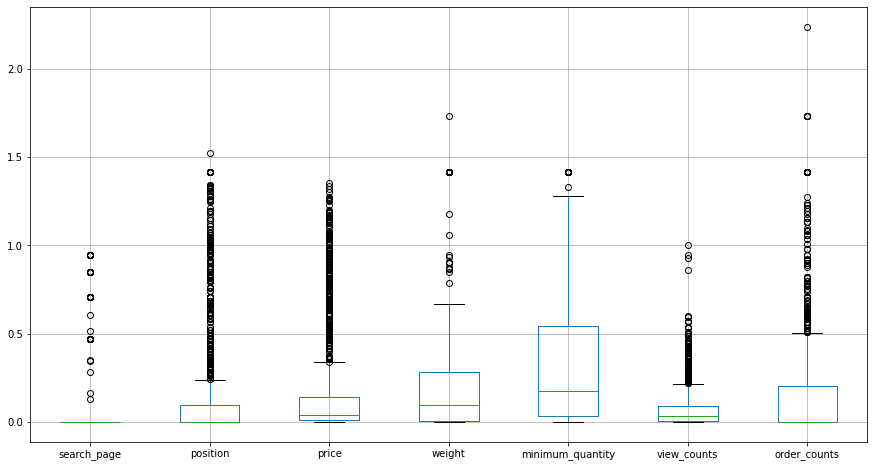

In [187]:
unique_group_stats.boxplot(figsize=(15, 8))
plt.show()

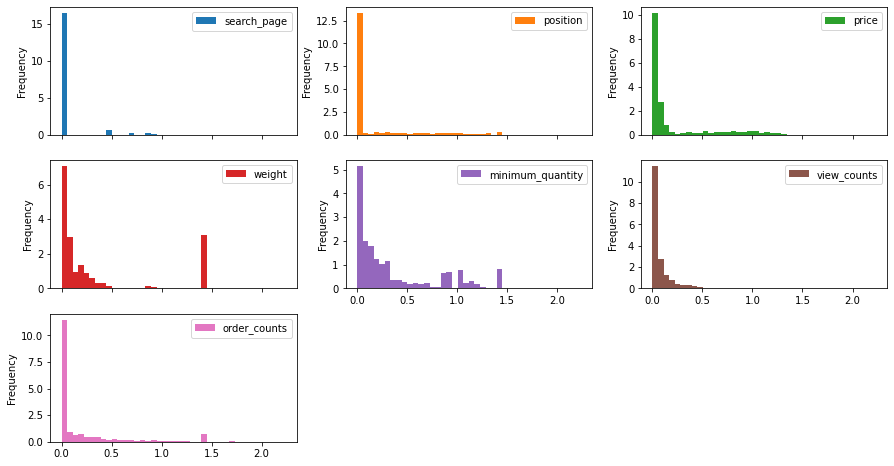

In [186]:
unique_group_stats.plot(subplots=True,
                        kind="hist",
                        layout=(3, 3),
                        figsize=(15, 8),
                        bins=40,
                        density=True)
plt.show()

Aparentemente as diferenças não são tão grandes. Boa parte delas talvez esteja
relacionada com diferenças nos tamanhos ou alguma possibilidade de customização
de um mêsmo produto que fez com que o vendedor necessitasse inserir um mêsmo
produto multiplas vezes.

Também existem duas outras possíveis explicações: o vendedor duplicando algum
produto para que seus produtos tenham mais visibilidade nas querys, o vendedor
atualizando o produto e esquecendo de remover algum produto antigo.

Para agilizar o desenvolvimento da solução vamos prosseguir com a análise sem
realizar mais investigações nesse ponto. A solução provisória para o problema
de duplca contagem de combinações de produto, vendedor e query será pela
combinação desses registros pela média das variáveis numéricas e moda das
variáveis categóricas.

### Removendo registros duplicados

Com base no que foi discutido anteriormente, nessa etapa iremos remover os
registros duplicados. Para juntar esses registros em uma só observação iremos
utilizar a moda para as variáveis categóricas e média para as variáveis
numéricas. Co excessão da `express_delivery` a aplicação da moda não fará
difença, uma vez que não há variação nessas colunas.

In [243]:
def series_mode(serie: pd.Series):
    return stats.mode(serie)[0][0]

def remove_duplicates(data: pd.DataFrame,
                      group: list[str],
                      mean_cols: list[str],
                      mode_cols: list[str]) -> pd.DataFrame:
    """Remoção de dados duplicados a partir de combinação de group. Utiliza
    mean_cols e mode_cols para unificar os registros em média e moda das
    observações duplicadas

    Args:
        data (pd.DataFrame): dataset
        group (list[str]): grupo que identifica unificamente o registro
        mean_cols (list[str]): variáveis a serem unificadas pela média
        mode_cols (list[str]): variáveis a serem unificadas pela moda

    Returns:
        pd.DataFrame: dataset sem registros duplicados
    """    
    duplicated_mask = data[group].duplicated(keep=False)
    
    dupli_data = data.loc[duplicated_mask]
    mode_stats = {col: series_mode for col in mode_cols}
    mean_stats = {col: "mean" for col in mean_cols}
    agg_stats = dict(**mode_stats, **mean_stats)
    unified_dupli_data = (dupli_data.
                          groupby(group, as_index=False).
                          agg(agg_stats))
    
    no_duplit_data = data.loc[~duplicated_mask]
    return pd.concat([no_duplit_data, unified_dupli_data])

In [225]:
no_dupli_df = remove_duplicates(df, unique_grouping, numeric_vars, equal_candidates)

In [232]:
no_dupli_df[unique_grouping].duplicated().any() == False

True

In [233]:
no_dupli_df.dtypes

product_id                    int64
seller_id                     int64
query                        object
search_page                 float64
position                    float64
title                        object
concatenated_tags            object
creation_date        datetime64[ns]
price                       float64
weight                      float64
express_delivery              int64
minimum_quantity            float64
view_counts                 float64
order_counts                float64
category                     object
dtype: object